# Compartments & Saddleplots

Welcome to the compartments and saddleplot notebook for cooltools manuscript.

This is based on [Open2C_examples](https://github.com/open2c/open2c_examples/blob/master/compartments_and_saddles.ipynb).

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import pandas as pd
import os, subprocess

In [2]:
plt.style.use("bmh")
plt.rcParams.update({"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

In [3]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools.lib import numutils

In [4]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
import cooltools
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


## Calculating per-arm compartmentalization

We first load the Hi-C data at 100 kbp resolution. 

Note that the current implementation of eigendecomposition in cooltools assumes that individual regions can be held in memory-- for hg38 at 100kb this is either a 2422x2422 matrix for chr2, or a 3255x3255 matrix for the full cooler here.

In [5]:
clr = cooler.Cooler('test.mcool::resolutions/100000')

In [ ]:
## fasta sequence is required for calculating binned profile of GC conent
if not os.path.isfile('./hg38.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz', shell=True)
    subprocess.call('gunzip hg38.fa.gz', shell=True)

In [6]:
import bioframe
bins = clr.bins()[:]
hg38_genome = bioframe.load_fasta('./hg38.fa');
## note the next command may require installing pysam
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
gc_cov.to_csv('hg38_gc_cov_100kb.tsv',index=False,sep='\t')
display(gc_cov)

,chrom,start,end,GC
0,chr2,0,100000,0.435867
1,chr2,100000,200000,0.409530
2,chr2,200000,300000,0.421890
3,chr2,300000,400000,0.431870
4,chr2,400000,500000,0.458610
...,...,...,...,...
3250,chr17,82800000,82900000,0.528210
3251,chr17,82900000,83000000,0.518530
3252,chr17,83000000,83100000,0.561450
3253,chr17,83100000,83200000,0.535119


In [7]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


Cooltools also allows a view to be passed for eigendecomposition to limit to a certain set of regions. The following code creates the simplest view, of the two chromosomes in this cooler.

To capture the pattern of compartmentalization within-chromosomes, in cis, cooltools `eigs_cis` first removes
the dependence of contact frequency by distance, and then performs eigenedecompostion. 

In [8]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis( 
                        clr, 
                        gc_cov, 
                        view_df=hg38_arms, 
                        n_eigs=5,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end', 'E1', 'E2', 'E3', 'E4', 'E5']]

In [18]:
def plot_mat_vecs(ax, mat, vec, vmin=0.1, vmax=1.9, n="linear", ymin=None, ymax=None, cols=['red', 'blue']):
    #
    ax.imshow(
        mat,
        cmap="RdBu_r",
        norm=colors.Normalize(vmin,vmax) if n=="linear" else colors.LogNorm(vmin,vmax),
        interpolation="none"
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    if vec is not None:
        divider = make_axes_locatable(ax)
        #
        ax2 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
        ax2.plot(np.arange(vec.size), vec, linewidth=0.5, color='k')
        # ax2.axhline(0, color='k')
        th = 0 # np.median(vec)
        ax2.fill_between(np.arange(vec.size), vec, th, where=(vec >= th), color=cols[0])
        ax2.fill_between(np.arange(vec.size), vec, th, where=(vec <= th), color=cols[1])
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.grid(False)
        ax2.set_frame_on(False)
        ax2.set_xlim(0, vec.size)
        
        if ymin is not None:
            ax2.set_ylim((ymin, ymax))
            
        ymin, ymax = ax2.get_ylim()

        ax1 = divider.append_axes("left", size="20%", pad=0.25, sharey=ax)
        ax1.plot(vec, np.arange(vec.size), linewidth=0.5, color='k')
        ax1.fill_betweenx(np.arange(vec.size), vec, th, where=(vec >= th), color=cols[0])
        ax1.fill_betweenx(np.arange(vec.size), vec, th, where=(vec <= th), color=cols[1])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.grid(False)
        ax1.set_frame_on(False)
        ax1.set_xlim((ymax, ymin))
        ax1.set_ylim(vec.size,0)


In [10]:
from cooltools.api import snipping

In [11]:
expected = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=2, chunksize=1_000_000)
oe_snipper = snipping.ObsExpSnipper(clr, expected, view_df=hg38_arms)

In [12]:
chrom, start, end = ("chr2", 141_000_000, 157_000_000)
region = f"{chrom}:{start}-{end}"
feature_table = pd.DataFrame([[chrom, start, end]], columns=["chrom", "start", "end"])

feature_table = bioframe.assign_view(feature_table, hg38_arms)
feature_table.columns = ["chrom", "start", "end", "region"]


In [13]:
df_eigvec = bioframe.select(eigenvector_track, region)
lo, hi = clr.extent(region)

matrix = np.log2(snipping.pileup_legacy(
            feature_table, 
            oe_snipper.select, 
            oe_snipper.snip
            ) )[:, :, 0]
matrix[np.isnan(matrix)] = 0
# Produce the full square:
matrix += matrix.T

In [28]:
import matplotlib as mpl

In [35]:
cmap = mpl.cm.get_cmap('Greys', 10)

<ipython-input-48-9f7ae4e148e0>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  mat_vec = np.sum( np.outer(df_eigvec.loc[:, f"E{i+1}"],


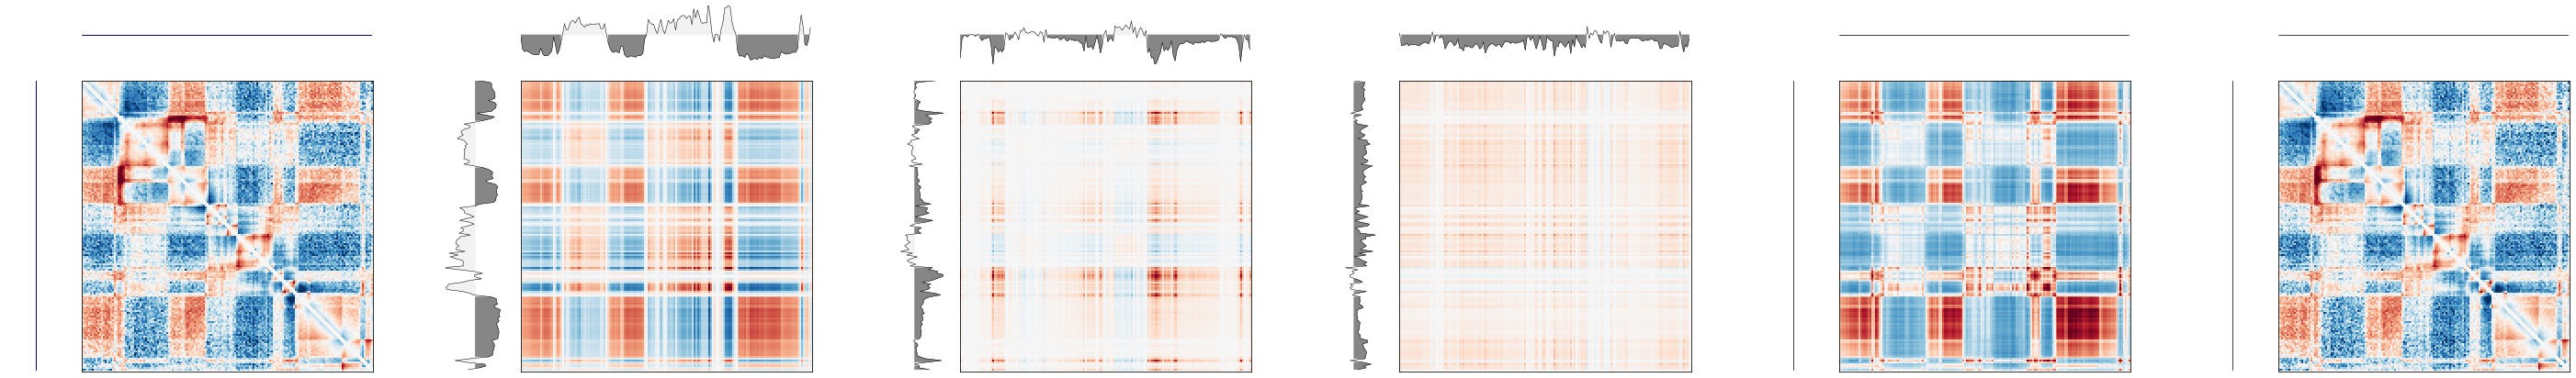

In [48]:
fig, axs = plt.subplots(ncols=6, **dict(figsize=(50,9), facecolor="white"))

vector = df_eigvec.loc[:, "E1"]
plot_mat_vecs(axs[0], matrix, np.zeros(vector.size), vmin=-2.5, vmax=2.5)

for i in [0, 1, 2]:
    vector = df_eigvec.loc[:, f"E{i+1}"]
    plot_mat_vecs(axs[i+1], np.outer(vector, vector), vector, 
                  vmin=-1.5, vmax=1.5, ymin=-1.2, ymax=1.2, 
                  cols=[cmap(0.15), cmap(0.5)])
    
# Plot the sum of EVs outer products

mat_vec = np.sum( np.outer(df_eigvec.loc[:, f"E{i+1}"], 
                           df_eigvec.loc[:, f"E{i+1}"])*np.sign( bioframe.select(cis_eigs[0], region)[f'eigval{i+1}'].values[0] ) for i in range(5))

plot_mat_vecs(axs[4], mat_vec, np.zeros(vector.size), 
              vmin=-1.5, vmax=1.5, cols=[cmap(0.15), cmap(0.5)])
plot_mat_vecs(axs[5], matrix, np.zeros(vector.size), 
              vmin=-2.5, vmax=2.5, cols=[cmap(0.15), cmap(0.5)])

# plt.savefig("decomposition.pdf")

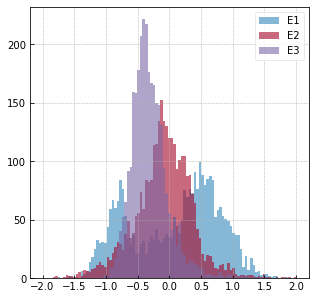

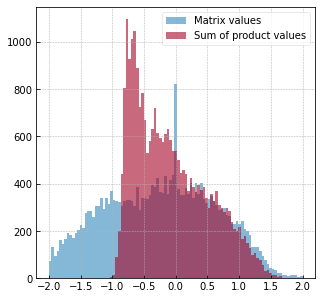

In [17]:
# Control plots of distributions
plt.figure(facecolor="white", figsize=[5,5])
bins = np.linspace(-2, 2, 100)

for i in [0, 1, 2]:
    vector = eigenvector_track.loc[:, f"E{i+1}"]
    plt.hist(vector, bins=bins, alpha=0.6, label=f"E{i+1}")

plt.legend()


plt.figure(facecolor="white", figsize=[5,5])
bins = np.linspace(-2,2,100)

plt.hist(matrix.flatten(), bins=bins, alpha=0.6, label="Matrix values")
plt.hist(mat_vec.flatten(), bins=bins, alpha=0.6, label="Sum of product values")

plt.legend()

plt.show()

### Plot the saddleplot

In [50]:
Q_LO = 0     # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 1.0   # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 5 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

In [51]:
eigtrack = eigenvector_track[['chrom', 'start', 'end', 'E1']]
digitized_track, binedges = cooltools.digitize(
    eigtrack, n_bins=N_GROUPS, vrange=None, qrange=(Q_LO,Q_HI)
)

# generate saddles-plots
interaction_sum, interaction_count =  cooltools.saddle(
        clr,
        expected,
        eigenvector_track,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=hg38_arms
)

In [52]:
def vecvalue_tospans(vec, value):
    """
    turn indices of elements where vec==value to
    spans of indices for axvspan visualization
    """
    _vec = vec.to_numpy().flatten()
    value_idxs = np.argwhere(_vec==value).flatten()
    
    # diff of matches indices - to get indices where "transition" happens
    diff_vec = np.diff(value_idxs)
    msk1 = np.r_[diff_vec, 1] != 1
    msk2 = np.r_[1, diff_vec] != 1
    
    # span borders d2-froms, d1-tos ...
    d1 = np.r_[value_idxs[msk1], value_idxs[-1]]  # add last value here
    d2 = np.r_[value_idxs[0], value_idxs[msk2]] #value_idxs[msk2]
    
    # return list of zipped spans
    return list( zip(d2, d1) )

In [53]:
import matplotlib.patches as patches

<ipython-input-54-9d66039c9c2c>:29: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(fv, fv, **vspan_kwd)
<ipython-input-54-9d66039c9c2c>:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(tv, tv, **vspan_kwd)
<ipython-input-54-9d66039c9c2c>:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axhspan(fv, fv, **vspan_kwd)
<ipython-input-54-9d66039c9c2c>:32: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axhspan(tv, tv, **vspan_kwd)
<ipython-input-54-9d66039c9c2c>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vec_dig[vec_dig!=selected_level] = np.nan
<ipython-input-54-9d66039c9c2

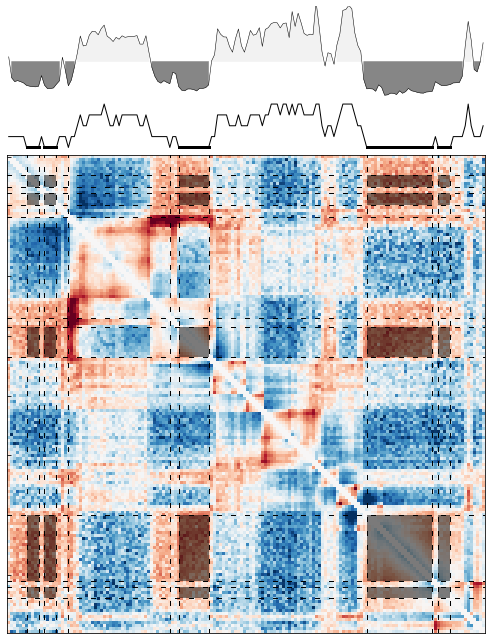

In [54]:
selected_level = 1

fig, axs = plt.subplots(ncols=1, tight_layout=True, **dict(figsize=(9,9), facecolor="white"))

vspan_kwd = dict(color="black", edgecolor="black", linewidth=1, linestyle=(0,(4,10))) # alpha=0.3, 

ax = axs

mat = matrix
vec = bioframe.select(eigenvector_track, region)['E1']
vec_dig = bioframe.select(digitized_track, region)['E1.d']

vmin = -2.5
vmax = 2.5
n = "linear"

vecspans = vecvalue_tospans(vec_dig, selected_level)

#
ax.imshow(
    mat,
    cmap="RdBu_r",
    norm=colors.Normalize(vmin, vmax) if n=="linear" else colors.LogNorm(vmin,vmax),
    interpolation="none"
)
ax.set_xticklabels([])
ax.set_yticklabels([])
for fv, tv in vecspans:
    ax.axvspan(fv, fv, **vspan_kwd)
    ax.axvspan(tv, tv, **vspan_kwd)
    ax.axhspan(fv, fv, **vspan_kwd)
    ax.axhspan(tv, tv, **vspan_kwd)

for fvi, tvi in vecspans:
    for fvj, tvj in vecspans:
        rect = patches.Rectangle((fvi, fvj), tvi-fvi, tvj-fvj, linewidth=0, facecolor='k', alpha=0.5) #edgecolor='black', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    
divider = make_axes_locatable(ax)

ax2 = divider.append_axes("top", size="10%", pad=0.08, sharex=ax)
ax1 = divider.append_axes("top", size="20%", pad=0.00, sharex=ax)

ax1.plot(np.arange(vec.size), vec, linewidth=0.5, color='k')
ax1.fill_between(np.arange(vec.size), vec, np.median(vec), where=(vec>=np.median(vec)), color=cmap(0.15))
ax1.fill_between(np.arange(vec.size), vec, np.median(vec), where=(vec<=np.median(vec)), color=cmap(0.5))
ax1.set_ylim((-1.2, 1.2))

ax2.plot(np.arange(vec_dig.size), vec_dig, linewidth=1, color='k')

vec_dig[vec_dig!=selected_level] = np.nan
ax2.plot(np.arange(vec_dig.size), vec_dig, linewidth=3, color='k')   


ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_frame_on(False)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.grid(False)
ax2.set_frame_on(False)

ax.grid(False)

plt.savefig("compartmental-areas.pdf")

<ipython-input-56-8eda7609de33>:2: RuntimeWarning: invalid value encountered in true_divide
  np.log2((interaction_sum/interaction_count)[1:-1,1:-1]),


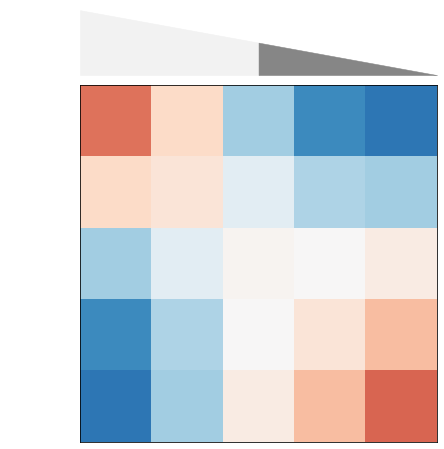

In [56]:
plt.imshow(
    np.log2((interaction_sum/interaction_count)[1:-1,1:-1]),
    cmap="RdBu_r",
    vmin=-2,
    vmax=2
    #norm = colors.LogNorm(vmin=0.5, vmax=2)
)
fig = plt.gcf()
fig.set_facecolor("white")
ax = plt.gca()
divider = make_axes_locatable(ax)

#
vec_dig = bioframe.select(digitized_track, region)['E1.d']
mean_values = vec.groupby(vec_dig).mean().loc[1:N_GROUPS]


ax2 = divider.append_axes("top", size="20%", pad=0.09, sharex=ax)

ax2.fill_between([-0.5, N_GROUPS//2], [1, 0.5], 0, color=cmap(0.15))
ax2.fill_between([N_GROUPS//2, N_GROUPS-0.5], [0.5, 0], 0, color=cmap(0.5))

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.grid(False)
ax2.set_frame_on(False)
ymin, ymax = ax2.get_ylim()


ax1 = divider.append_axes("left", size="20%", pad=0.02, sharey=ax)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_frame_on(False)
ax1.set_xlim((ymax, ymin))

plt.savefig("saddleplot.pdf")